# IEOR 243 Group 10 Module 2


We want to address the following questions through code and our report:

#### What is the goal of our models and what are you trying to achieve?

Our general goal is to understand how people felt about COVID in 2020 and compare it to how people felt about COVID in 2023. We also want to be more specific than a simple sentiment analysis in which we score sentiment on a -10 to 10 scale (or something comparable). We want to be able to capture the full range of emotions that people convey about COVID. For instance, people may be sad about losing a loved one, scared about getting sick or losing money, angry (or happy) about policy created by legislators, etc. These emotions should not be abstracted into a single number necessarily. 

#### What models and methodologies have you used?

We are in an interesting scenario because our data is *not labeled* meaning we cannot train any supervised learning models to predict sentiment, emotions, etc. We have over 100k rows so manually labeling the data is infeasible. Instead, we introduce three modeling approaches to analyze our problem.

1) **K-Means Clustering**: We begin by creating a K-Means clustering algorithm on the `text` column in our data to understand the general trends of communication. 

    * **K-Means Clusters as Labels**: We then sample tweets from each cluster, cobmine them together, and run inference on a pre-trained summarization model to arrive as cluster descriptions to use with our Zero-Shot models later.


2) **Zero-Shot Classification with Hugging Face SOTA**: Hugging Face hosts many open-source, pre-trained models for sentiment analysis and text-classification. We'll apply a few of these models for zero-shot classification on our data to see how it performs. This is difficult to compare to an unsupservised model, but gives us a more useful model. 


3) **Unsupervised Text Classification through Lbl2Vec**: Lbl2Vec is a rather new algorithm published in 2021 (paper: https://www.scitepress.org/Link.aspx?doi=10.5220/0010710300003058) which automatically generates jointly embedded label, document and word vectors and returns documents of categories modeled by manually predefined keywords. The key idea of the algorithm is that many semantically similar keywords can represent a category. We'll compare this to the zero-shot learning from Hugging Face, along with our K-Means clustering to see how it performsn.

#### How have you selected any tuning parameters for your models (a.k.a hyperparameters)?

While most supervised learning algorithms benefit greatly from using a standard K-Fold cross-validation implementation using Scikit-Learn's `GridSearchCV` object, for K-Means clustering, it's quite common to use the "elbow method." Instead of directly minimizing some evaluation metric like SSE or Inertia, we instead will search over a space of reasonable values of `n_clusters` and plot the corresponding silhouette scores. We will select a quasi-optimal value of `n_clusters` by selecting the one on the "elbow" of the plot.

#### How well does your model perform and how have you measured that?


#### Are there any significant limitations to your modeling methods (i.e. Where, when, how, and why can your model fail? )


In [87]:
# General Imports 
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
from typing import List
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
# NLTK Imports 
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk import SnowballStemmer
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bennettcohen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/bennettcohen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [55]:
# Modeling Imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

## Preprocessing

First, we load in the uncleaned data and apply the data cleaning steps from Module 1. Please refer to the `ieor_243_group_10_module_1.ipynb` notebook for an in-depth explanation of this process.

In [4]:
# Load data 
parent_path = "../data"
df20 = pd.read_csv(f"{parent_path}/covid2020.csv")
df23 = pd.read_csv(f"{parent_path}/covid2023.csv")

In [41]:
# Preprocessing Helper Functions
def preprocess_text(text: str) -> str:
    # convert to lowercase
    text = text.lower()
    
    # remove URLs
    text = re.sub(r"http\S+", "", text)
    
    # remove numbers
    text = re.sub(r"\d", "", text)
    
    # remove punctuation
    text = re.sub(r"[^\w\s]", "", text)
    
    # remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    
    # Removing extra spaces
    text = " ".join(tokens)
    text = re.sub(' +', ' ', text)
    
    # Removing Emojis
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # Removing emoticons
    text = re.sub(r':\w+:', '', text)
    
    # Removing Contractions
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    # Remove words that are shorter than 2 letters or longer than 20 letters
#     text = re.sub(r'\b\w{1,2}\b|\b\w{21,}\b', "", text)
    
    # Remove the word "covid"
#     text = re.sub("covid", "", text)
    
    return text

def preprocess_nulls(df: pd.DataFrame) -> pd.DataFrame: 
    
    # Drop duplicate rows 
    df = df.drop_duplicates(subset = "text")
    
    # Drop rows with no followers 
    df = df[df['user_followers'] > 0]
    
    # Drop nulls and reset index 
    df = df.dropna().reset_index(drop = True)
    
    
    return df

def remove_emojis(column):
    return re.sub(r'[^\x00-\x7F]+', '', column)

def stem_text(stemmer: SnowballStemmer, text):
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

def get_short_long_words(list_of_tokens: str):
    two_letter_words = []
    for token in list_of_tokens:
        if len(token) <= 2 or len(token) >= 21:
            two_letter_words.append(token)
    return two_letter_words

def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
    
    # Preprocess null and missing values 
    df = preprocess_nulls(df)
    
    # Preprocess text 
    df['processed_text'] = df['text'].apply(preprocess_text)
    
    # Remove emojis from certain columns
    emoji_cols = ['user_name', 'user_location', 'user_description']
    for col in emoji_cols: 
        df[col] = df[col].apply(remove_emojis)
            
    # Apply word stemming
#     stemmer = SnowballStemmer(language = "english")
#     df['text'] = df['text'].apply(lambda x: stem_text(stemmer = stemmer, text = x))
    
    return df

In [42]:
# Process the data and extract text columns
df20 = preprocess_df(df20)
df23 = preprocess_df(df23)

X20 = df20['processed_text']
X23 = df23['processed_text']

## Tokenization

In [43]:
# Apply a TFIDF Vectorizer (count vec with normalization) 
vectorizer = TfidfVectorizer(max_df = 0.5, min_df = 5, stop_words = 'english')
X20_vec = vectorizer.fit_transform(X20)
X23_vec = vectorizer.fit_transform(X23)

## Method #1: K-Means Clustering

We search over a space `n_cluster` values from 2 to 9 and use the elbow method to select the value with the highest `silhouette_score` as our final model. We then plot the results below.

In [90]:
def train_kmeans(X, n_cluster_values: List[int], verbose: bool = True) -> dict: 
    
    """
    Function to train KMeans and run a parameter sweep over n_cluster_values 
    Params: 
        X: data to train on
        n_cluster_values: list of integers of the number of clusters to try
        random_seed: random seed to pass to KMeans estimator 
        verbose: bool
    Returns: 
        scores: dictionary of silhouette scores for each n_clusters value
    """
    
    # Search over a search space of n_cluster values 
    scores = {}
    tic = time.time()
    for n_clusters in n_cluster_values: 

        # Fit a model 
        kmeans = KMeans(n_clusters = n_clusters, random_state = 1)
        kmeans.fit(X)


        # Compute the silhouette score
        score = silhouette_score(X = X, 
                                 labels = kmeans.labels_, 
                                 metric = 'euclidean'
                                )
        scores.update({n_clusters: score})

        # Logging 
        if verbose: 
            print(f"n_clusters: {n_clusters} -- {time.time()-tic:2f} seconds")
            
    return scores

In [111]:
# Train the KMeans Estimator 
scores = train_kmeans(X = X20_vec, 
                      n_cluster_values = list(range(2, 8)), 
                      verbose = True)

n_clusters: 2 -- 137.010516 seconds
n_clusters: 3 -- 273.840298 seconds
n_clusters: 4 -- 483.278896 seconds
n_clusters: 5 -- 710.705920 seconds
n_clusters: 6 -- 941.100795 seconds
n_clusters: 7 -- 1159.495348 seconds


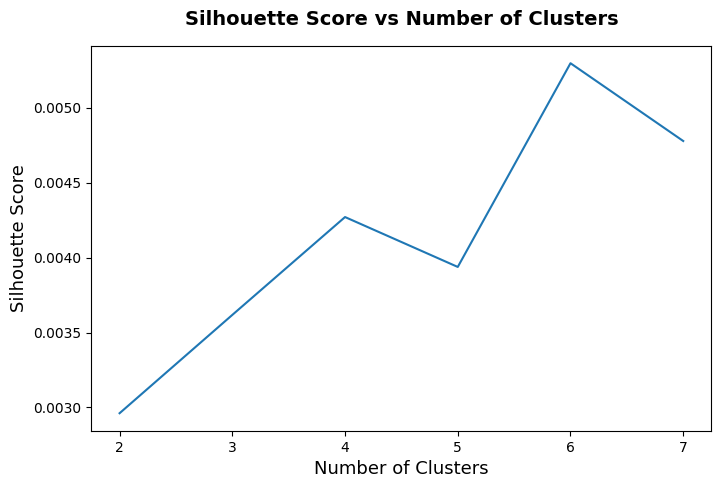

In [113]:
# Plot the Silhouette score results
fig, ax = plt.subplots(figsize = (8,5))

n_cluster_vals = list(scores.keys())
n_cluster_scores = list(scores.values())

plt.plot(n_cluster_vals, n_cluster_scores)

plt.title("Silhouette Score vs Number of Clusters", pad = 15, fontweight = 'semibold', fontsize = 14)
plt.xlabel("Number of Clusters", fontsize = 13)
plt.ylabel("Silhouette Score", fontsize = 13)

plt.xticks(n_cluster_vals, n_cluster_vals)
plt.show()

In [126]:
# Extract the best model and retrain it
optimal_n_clusters = list(scores.keys())[np.argmax(list(scores.values()))]
kmeans = KMeans(n_clusters = optimal_n_clusters, random_state = 1, max_iter = 5_000)
kmeans.fit(X20_vec)

KMeans(max_iter=5000, n_clusters=6, random_state=1)

In [128]:
# Add predictions to df and check the cluster distribution
df20['cluster'] = kmeans.predict(X20_vec)
df20['cluster'].value_counts(normalize = True)

1    0.746363
3    0.068322
4    0.062454
5    0.054970
2    0.041728
0    0.026162
Name: cluster, dtype: float64

## Method #1a: Using Pre-Trained Summarizers to Describe Clusters

Now that we have a well trained KMeans clustering algorithm, we want to understand (or label) these clusters. One common approach is to look manually and determine what each cluster entails, but we are more principled than that. Instead, we'll use a transformer-based summarization tool from Hugging Face in order to summarize what each cluster actually discusses. This will give us a clean 1 sentence summary of each cluster that we can use to contextualize our analysis.

**NOTE**: We will be running the summarization on the `text` instead of the `processed_text` column because the Hugging Face models generally have their own tokenization functions. We don't want to double-tokenize.

In [129]:
# Load in the summarizer from Hugging Face
summarizer = pipeline("summarization", model = "facebook/bart-large-cnn")

In [171]:
cluster_summaries = {}
for cluster in range(kmeans.n_clusters): 
    
    # Grab the tweets from the cluster 
    cluster_tweets = df20[df20['cluster'] == cluster]['text'].to_list()
    
    # Randomly Sample tweets
    n_samples = np.minimum(len(cluster_tweets), 50)
    sampled_tweets = random.sample(cluster_tweets, k = n_samples)
    
    # Join the sampled tweets 
    sampled_tweets_joined = ";".join(sampled_tweets)
    
    # Run the summarizer 
    res = summarizer(sampled_tweets_joined, max_length = 25, min_length = 25, do_sample = False)
    
    # Update the dict 
    cluster_summaries.update({cluster: res[0]['summary_text']})

In [173]:
cluster_summaries

{0: 'Covid spares one staysafe rammandir trust head nritya gopal das tests',
 1: 'Covid means many aspects life scuppered h;try convince number number bbozo even bother b',
 2: 'Reports covid cases increasing delhi reason many people outside del;telegraph thats even number people died covid',
 3: 'Covid asymptomatic children still spread coronavirus study shows covid kids childern;c',
 4: 'Covid positive tally crosses lakh mark spike new cases amp deaths last hours;covid highest spike cases',
 5: 'Covid accelerated digital trends laying ground tech media amp telecoms industry experience;covid pandemic leads'}

## Method #2: Zero-Shot Classification with Hugging Face SOTA

## Method #3: Unsupervised Text Classification through Lbl2Vec